# Predicting bicycle traffic by linear regression

This is my (i.e. Ben Lambert's) attempt to create a predictive model of bicycle traffic in Seattle. Crucially, it is not an attempt to answer the problem questions; rather, it is supposed to illustrate an overall approach to modelling data. It is also not supposed to be definitive: many different models can often provide an adequate explanation of the data.

Whenever you model data, you should take a critical approach to modelling. Always remember that a model is a simplified version of the world, so you need to ask whether the various simplifications are justified. As such, you need to take a proactive approach to searching for flaws in your models. Usually, the best way to elucidate these flaws is to visualise the data and model predictions, and I hope to demonstrate this approach here.

First, we load necessary packages and data.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df_bike = pd.read_csv("data/FremontBridge.csv")
df_weather = pd.read_csv("data/SeattleWeather.csv")

Convert column names to be all lowercase.

In [3]:
df_bike.columns = map(str.lower, df_bike.columns)
df_weather.columns = map(str.lower, df_weather.columns)

We notice that the date columns are in different formats, so we convert them to both be datetime objects.

In [4]:
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y-%m-%d")
df_bike["datetime"] = pd.to_datetime(df_bike["date"], format="%m/%d/%Y %H:%M:%S %p")

The bike data is hourly; the weather data is daily. So we want to aggregate the former.

In [5]:
df_bike.head()

date  fremont bridge total  fremont bridge east sidewalk  \
0  10/03/2012 12:00:00 AM                  13.0                           4.0   
1  10/03/2012 01:00:00 AM                  10.0                           4.0   
2  10/03/2012 02:00:00 AM                   2.0                           1.0   
3  10/03/2012 03:00:00 AM                   5.0                           2.0   
4  10/03/2012 04:00:00 AM                   7.0                           6.0   

   fremont bridge west sidewalk            datetime  
0                           9.0 2012-10-03 12:00:00  
1                           6.0 2012-10-03 01:00:00  
2                           1.0 2012-10-03 02:00:00  
3                           3.0 2012-10-03 03:00:00  
4                           1.0 2012-10-03 04:00:00

In [6]:
df_weather.head()

station                           name       date   awnd  prcp  tavg  \
0  USW00024233  SEATTLE TACOMA AIRPORT, WA US 2012-10-03  16.33   0.0   NaN   
1  USW00024233  SEATTLE TACOMA AIRPORT, WA US 2012-10-04  14.54   0.0   NaN   
2  USW00024233  SEATTLE TACOMA AIRPORT, WA US 2012-10-05  12.75   0.0   NaN   
3  USW00024233  SEATTLE TACOMA AIRPORT, WA US 2012-10-06  11.41   0.0   NaN   
4  USW00024233  SEATTLE TACOMA AIRPORT, WA US 2012-10-07   2.91   0.0   NaN   

   tmax  tmin  
0    66    46  
1    66    47  
2    71    48  
3    75    46  
4    75    46

To do so, we create a column "date" which strips away time of day. We will use this variable to group by.

In [7]:
df_bike["date"] = pd.to_datetime(df_bike["datetime"].dt.strftime('%Y-%m-%d'), format="%Y-%m-%d")

In [8]:
df_bike.drop("datetime", axis=1, inplace=True)

Now let's aggregate the data to be daily.

In [9]:
df_bike = df_bike.groupby("date", as_index=False).agg(sum)
df_bike.head()

date  fremont bridge total  fremont bridge east sidewalk  \
0 2012-10-03                7042.0                        3520.0   
1 2012-10-04                6950.0                        3416.0   
2 2012-10-05                6296.0                        3116.0   
3 2012-10-06                4012.0                        2160.0   
4 2012-10-07                4284.0                        2382.0   

   fremont bridge west sidewalk  
0                        3522.0  
1                        3534.0  
2                        3180.0  
3                        1852.0  
4                        1902.0

And combine both datasets by merging. Note, that the datasets are merged according to common keys in both: here, `date` is a column in both datasets, so is what the datasets are merged on.

In [10]:
df_combined = pd.merge(df_bike, df_weather)
df_combined.head()

date  fremont bridge total  fremont bridge east sidewalk  \
0 2012-10-03                7042.0                        3520.0   
1 2012-10-04                6950.0                        3416.0   
2 2012-10-05                6296.0                        3116.0   
3 2012-10-06                4012.0                        2160.0   
4 2012-10-07                4284.0                        2382.0   

   fremont bridge west sidewalk      station                           name  \
0                        3522.0  USW00024233  SEATTLE TACOMA AIRPORT, WA US   
1                        3534.0  USW00024233  SEATTLE TACOMA AIRPORT, WA US   
2                        3180.0  USW00024233  SEATTLE TACOMA AIRPORT, WA US   
3                        1852.0  USW00024233  SEATTLE TACOMA AIRPORT, WA US   
4                        1902.0  USW00024233  SEATTLE TACOMA AIRPORT, WA US   

    awnd  prcp  tavg  tmax  tmin  
0  16.33   0.0   NaN    66    46  
1  14.54   0.0   NaN    66    47  
2  12.75   0.0   NaN    71    48  
3  11.41   0.0   NaN    75    46  
4   2.91   0.0   NaN    75    46

Before we do any modelling, we need to understand our data. Always the most powerful way to understand a dataset is to visualise it. So, that's what we'll do now.

In [11]:
from plotnine import *

I'm going to rename a few columns to make them easier to remember. Here, I will seek to model the "fremont bridge total" traffic opposed to its constituent parts.

In [12]:
df_combined["traffic"] = df_combined["fremont bridge total"]
df_combined["temperature"] = df_combined["tavg"]
df_combined["precipitation"] = df_combined["prcp"]

Let's now visualise: traffic and the two temperature variables. To do so, we first convert the dataset into long format.

In [13]:
df_long = (
    df_combined[["date", "traffic", "temperature", "precipitation"]].
    melt("date")
)

Then we can plot these using ggplot.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


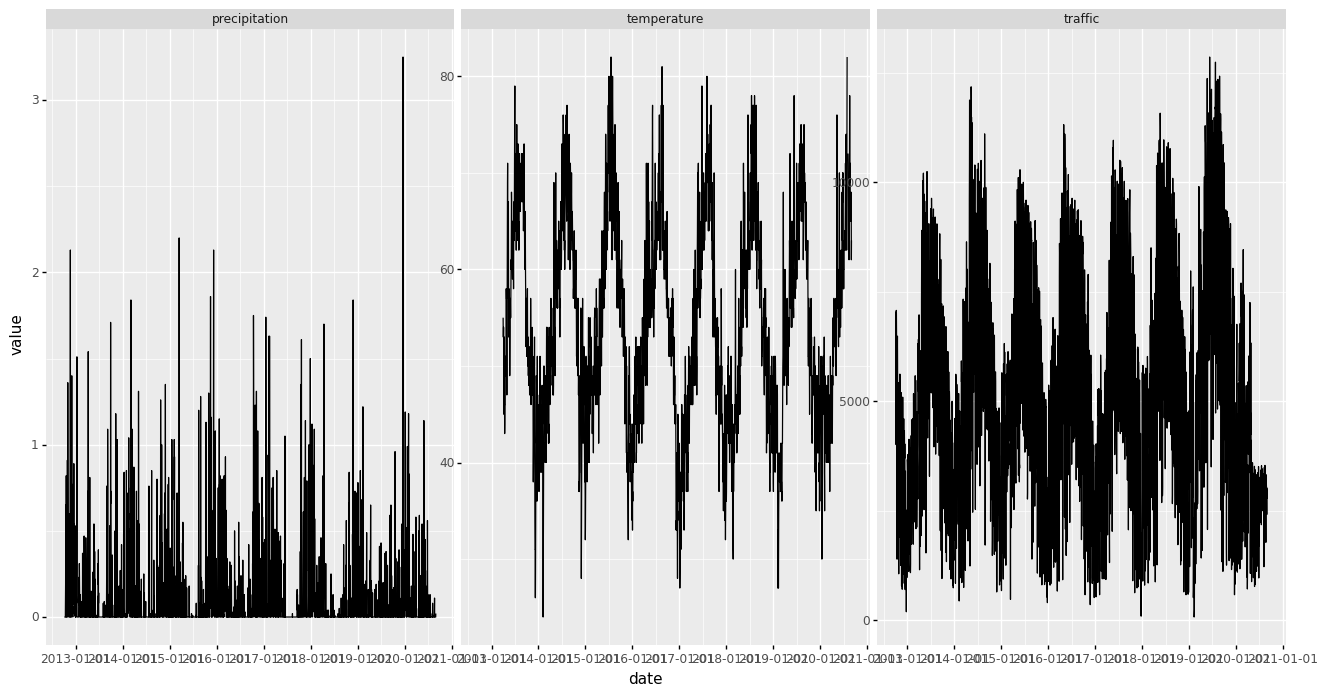

<ggplot: (8776155138226)>

In [14]:
(
    ggplot(df_long, aes(x='date', y='value')) +
    geom_line() +
    facet_wrap('variable', scales='free') +
    theme(figure_size=(16, 8))
)

Hmm, that's not the best visualisation. Let's look at traffic counts first. Perhaps we were getting ahead of ourselves.

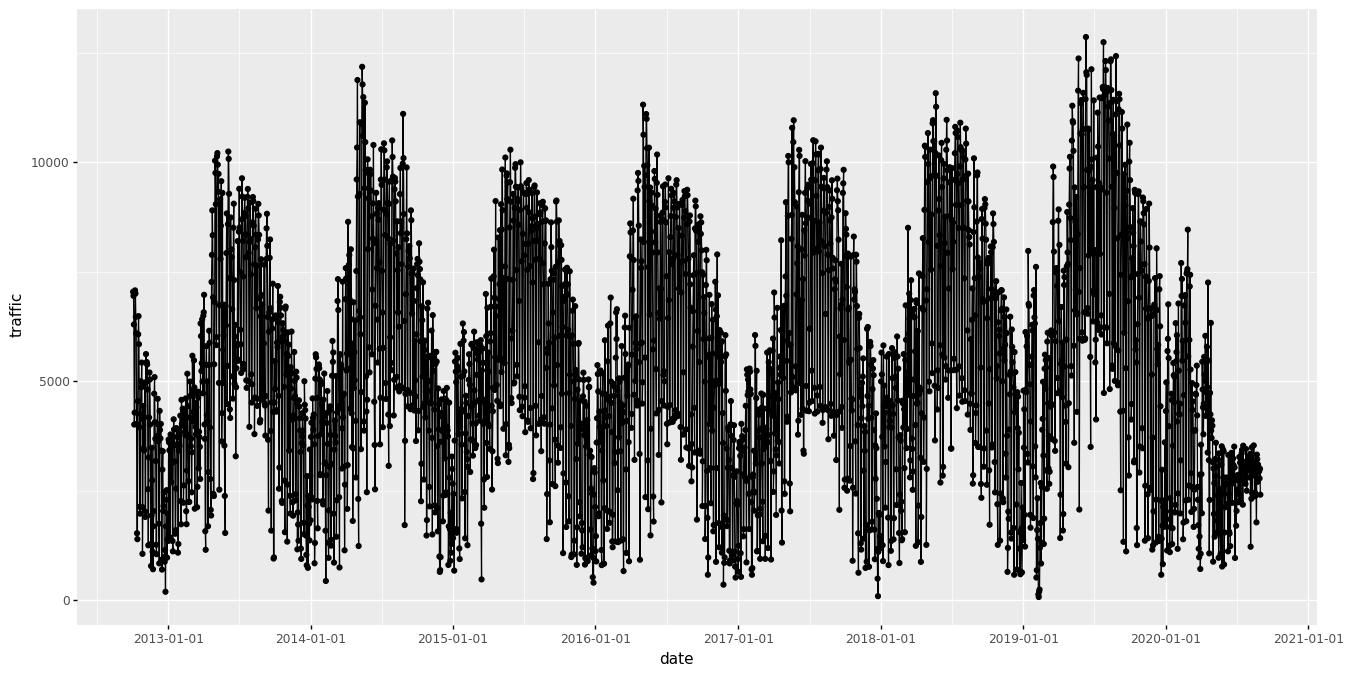

<ggplot: (8776137084049)>

In [15]:
(
    ggplot(df_combined, aes(x='date', y='traffic')) +
    geom_point() +
    geom_line() +
    theme(figure_size=(16, 8))
)

The above plot illustrates seasonal patterns in bike traffic. Which makes sense, since people likely decide which mode of transport to take based on a range of factors; one of these is likely the weather, which varies seasonally.

An alternative way to visualise the above data is to look at each year separately, which we do now.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


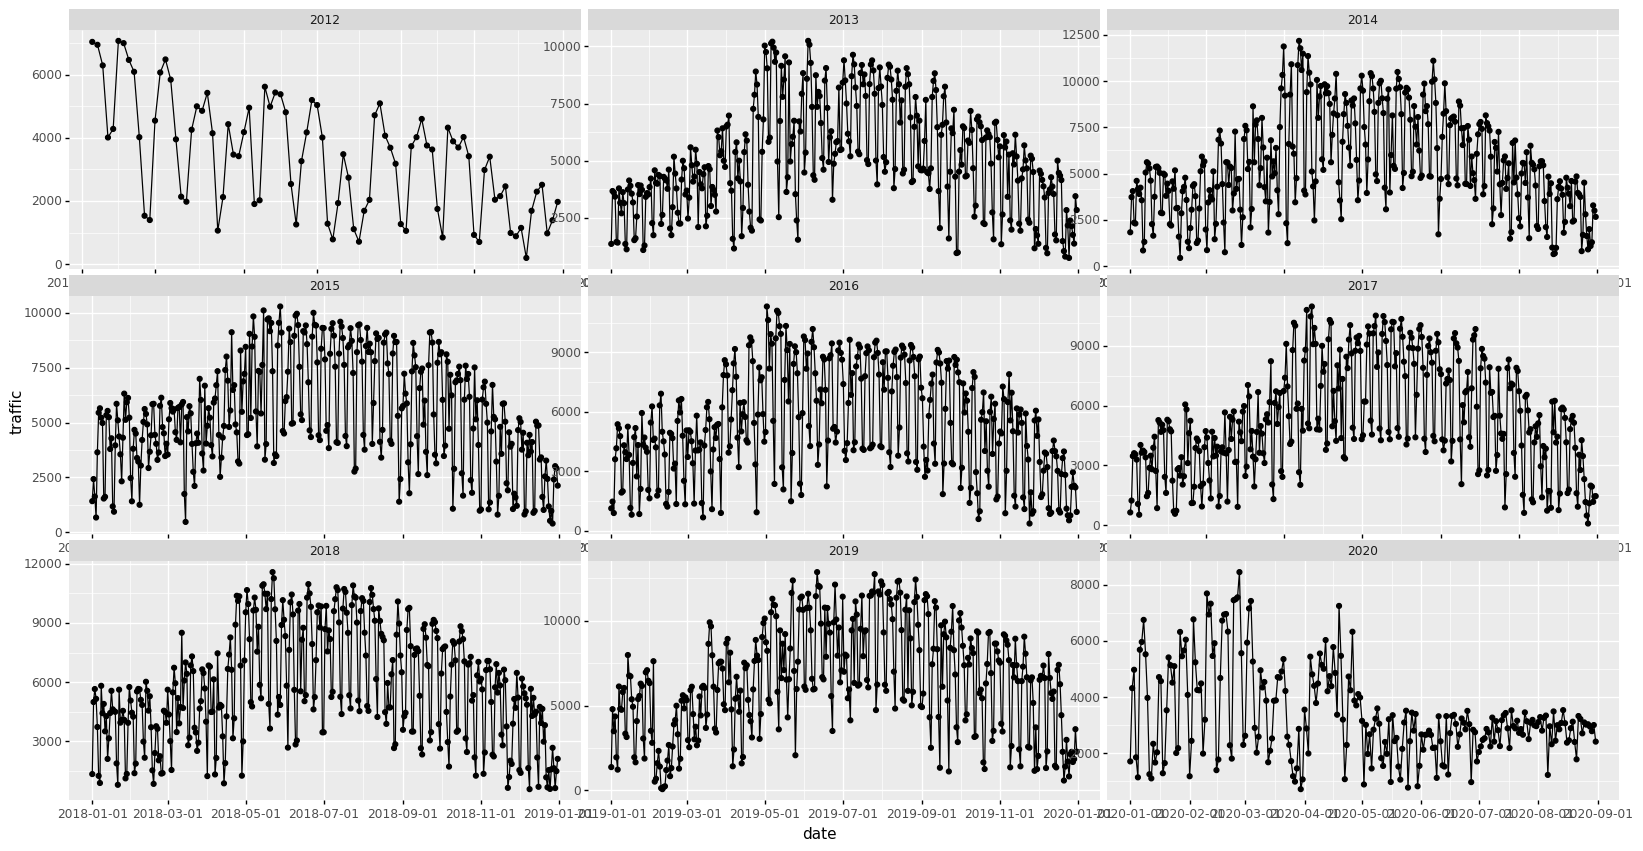

<ggplot: (8776155213234)>

In [16]:
df_combined["year"] = df_combined["date"].dt.year
(
    ggplot(df_combined, aes(x='date', y='traffic')) +
    geom_point() +
    geom_line() +
    facet_wrap('year', scales="free") +
    theme(figure_size=(20, 10))
)

This above plot shows that, clearly, there are some issues with 2012 and 2020. So, for the current analysis, we are going to drop them and replot.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


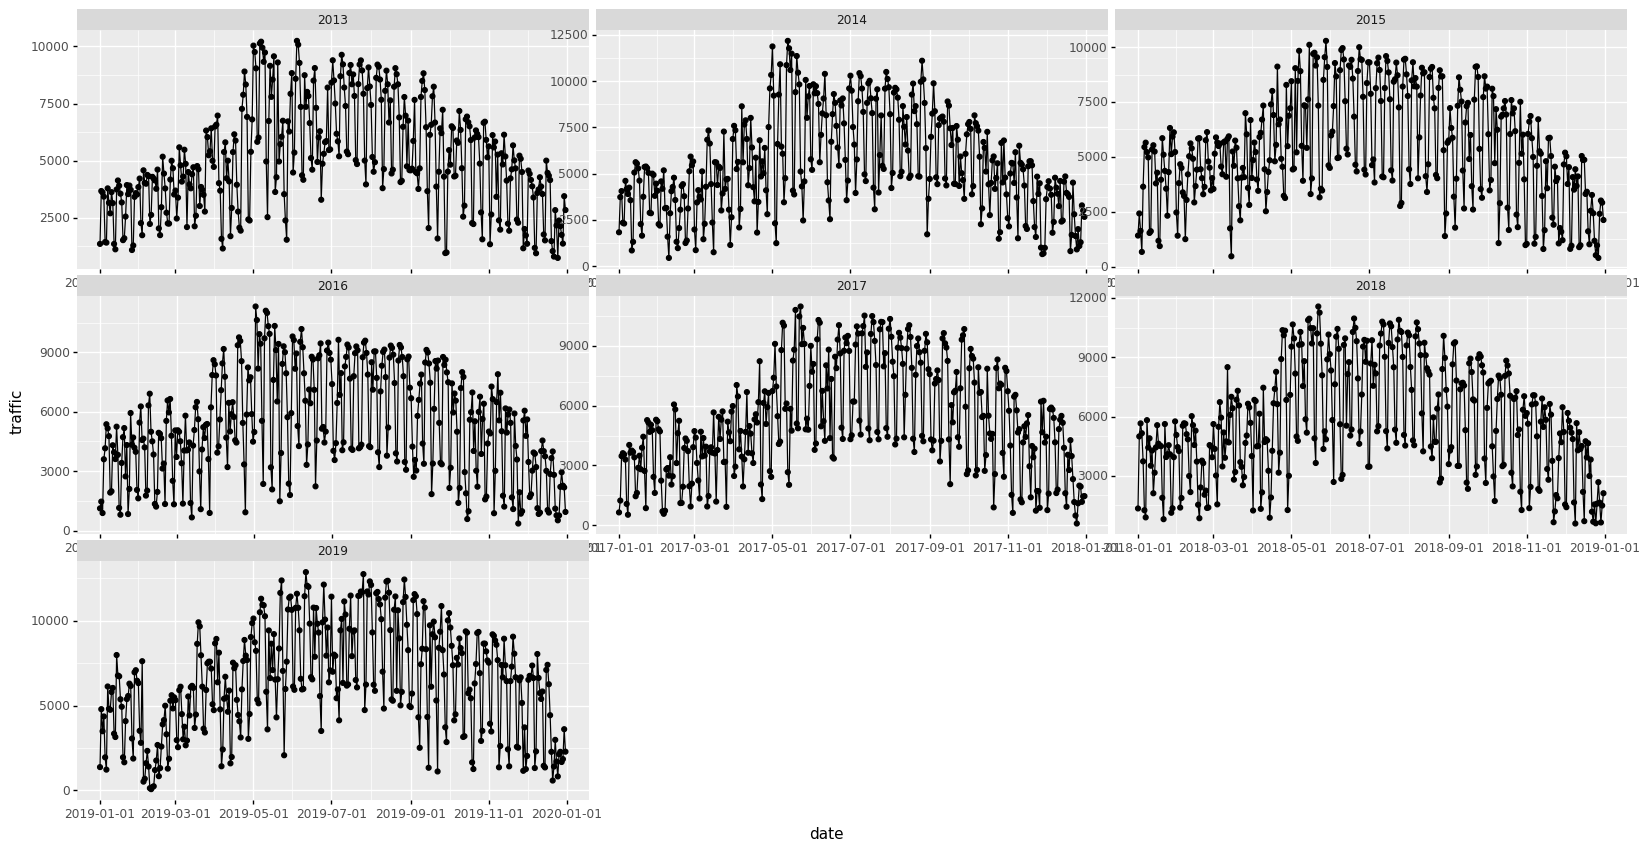

<ggplot: (8776137217232)>

In [17]:
df_combined = df_combined.query("year > 2012 & year < 2020")

(
    ggplot(df_combined, aes(x='date', y='traffic')) +
    geom_point() +
    geom_line() +
    facet_wrap('year', scales="free") +
    theme(figure_size=(20, 10))
)

Based on the above plots, there is clearly a degree of common seasonality across years. One way to model this seasonality is not to model it by proxy; assuming that the time of year effectively represents the whole gamut of other factors (such as weather, national holidays and so forth) that vary intra-annually.

The first model we fit to the data is a very simple one: a sine wave of a single frequency of the form:

$$y(t) = a + b \sin\left(\frac{2 \pi t}{365.25} + \phi\right)$$

We can expand out the sin using the double angle type formula:

$$\sin(x + z) = \sin(x) \cos(z) + \sin(z) \cos(x)$$

which means our model becomes:

$$ y(t) = a + b \sin(\frac{2 \pi t}{365.25}) \cos(\phi) + b \sin(\phi) \cos(\frac{2 \pi t}{365.25}),$$

which can be written as:

$$ y(t) = a + b_1 \sin(\frac{2 \pi t}{365.25}) + b_2 \cos(\frac{2 \pi t}{365.25}).$$

This is just a linear regression with two covariates: $\sin(\frac{2 \pi t}{365.25})$ and $\cos(\frac{2 \pi t}{365.25})$, and we will now attempt to fit this model to the traffic data. To do so, we need first to create our sine and cosine variables.

In [18]:
df_combined["t"] = np.arange(len(df_combined))

df_combined["sin_t"] = np.sin(2 * np.pi * df_combined["t"] / 365.25)
df_combined["cos_t"] = np.cos(2 * np.pi * df_combined["t"] / 365.25)

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/222675080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/222675080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/222675080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

We now fit this model via ordinary least squares.

In [19]:
lm = LinearRegression()
X = df_combined[["sin_t", "cos_t"]]
lm.fit(X, df_combined["traffic"])

LinearRegression()

Let's now look at the coefficients estimated.

First, the intercept, $a$, in the model above. This represents the average bike traffic across the whole year.

In [20]:
lm.intercept_

5559.30352907899

Next, we examine the regression coefficients, $b_1$ and $b_2$:

In [21]:
lm.coef_

array([ -311.21108052, -2330.50856596])

On their own, these regression coefficients aren't too informative. To try to understand how the model works, let's now make a prediction and visualise the model's performance vs the data.

In [22]:
df_combined["traffic_pred"] = lm.predict(X)

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3985895940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


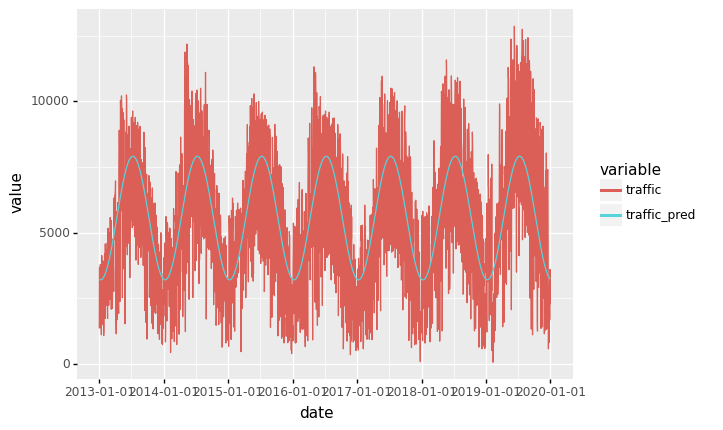

<ggplot: (8776137246031)>

In [23]:
df_new = (
    df_combined[["date", "traffic", "traffic_pred"]].
    melt("date")
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable'))
)

On first glances, the model appears to quite nicely represent the seasonality that is present in the data. However, let's examine this assumption by calculating the residuals.

In [24]:
df_combined["resid"] = df_combined["traffic"] - df_combined["traffic_pred"]

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/1497236194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Let's make a quick plot of the residuals.

<AxesSubplot:>

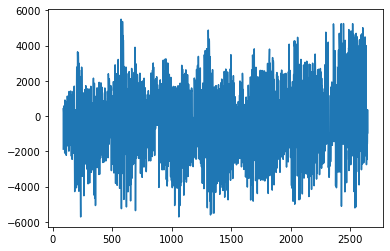

In [25]:
df_combined["resid"].plot()

Hmm, that's hard to see. Let's look at month by month residuals instead.

In [26]:
df_combined["month"] = df_combined["date"].dt.month
df_combined["year"] = df_combined["date"].dt.year
df_temp = df_combined.groupby(["month", "year"], as_index=False).apply(lambda x: pd.Series({'resid': np.mean(x.resid)}))

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3371011744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3371011744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


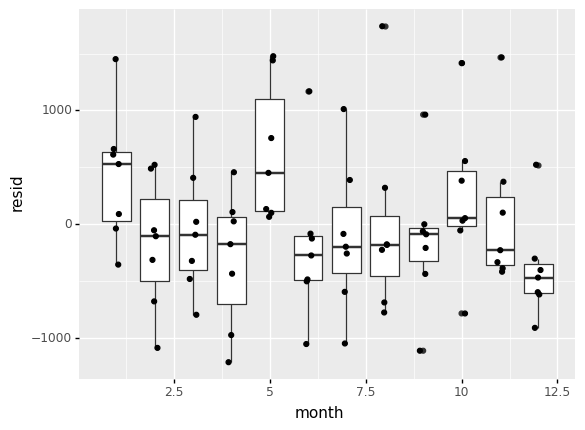

<ggplot: (8776173836319)>

In [27]:
(
    ggplot(df_temp, aes(x='month', y='resid', group='month')) +
    geom_boxplot() +
    geom_jitter(width=0.1)
)

It looks like our model is mischaracterising the winter period and, to some extent, the summer. Let's look at our model predictions for a single year: here, we arbitrarily pick 2015.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/1744450829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


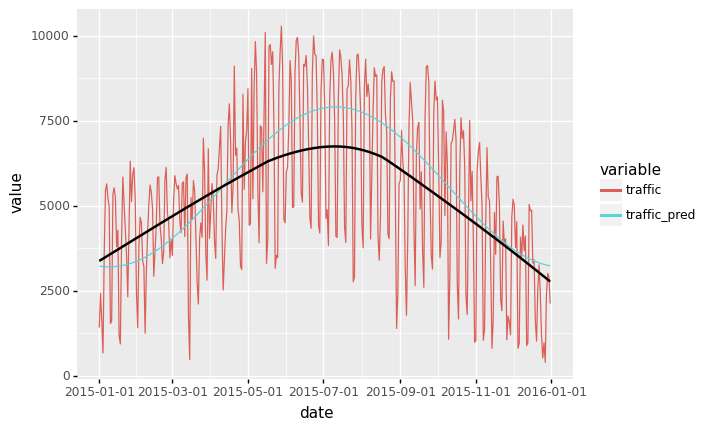

<ggplot: (8776137296933)>

In [28]:
df_combined["year"] = df_combined["date"].dt.year
df_temp = df_combined.query("year == 2015")
df_new = (
    df_temp[["date", "traffic", "traffic_pred"]].
    melt("date")
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    geom_smooth(data=df_new.query("variable == 'traffic'"))
)

Ok, so the sine wave is not quite right. That's hardly surprising: why should seasonal trends follow a simple sine curve? Life is likely more complicated than this.

An alternative approach is to devise a model with weekly dummy variables, which capture at a more finescaled level the intra-annual variation.

Let's try to fit this model. To do so, we create dummy variables for each week of the year then refit this model.

In [29]:
df_dummies = pd.get_dummies(df_combined["date"].dt.week)
df_dummies.drop(1, inplace=True, axis=1)

lm = LinearRegression()
lm.fit(df_dummies, df_combined["traffic"])

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/2016496675.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


LinearRegression()

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3889616770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


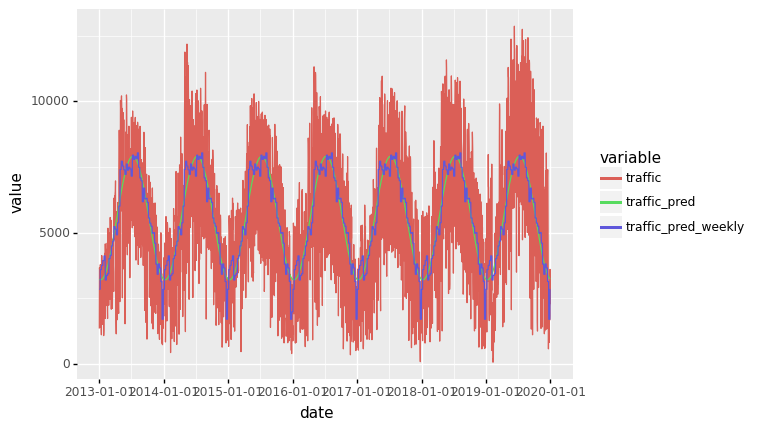

<ggplot: (8776188568068)>

In [30]:
df_combined["traffic_pred_weekly"] = lm.predict(df_dummies)

df_new = (
    df_combined[["date", "traffic", "traffic_pred", "traffic_pred_weekly"]].
    melt("date")
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable'))
)

The above compares the weekly predictions with the pure sine curve. Actually, looking at this, it doesn't seem like the sine curve is as bad as it might first appear. But, the weekly dummy variables do pick up a few more crucial pieces of information: first and foremost, that the winter holidays appear to have substantially lower levels of bike traffic.

There are pros and cons of this model: it shows us that there are some dynamics in traffic that are not captured by a smooth curve: namely those around the winter holidays. It does, however, fit a somewhat jagged curve and is a more complex model than the pure sine curve model.

The residual series do look much better now, however: we are not persistently mischaracterising traffic flows throughout the year.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3602512903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3602512903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/3602512903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

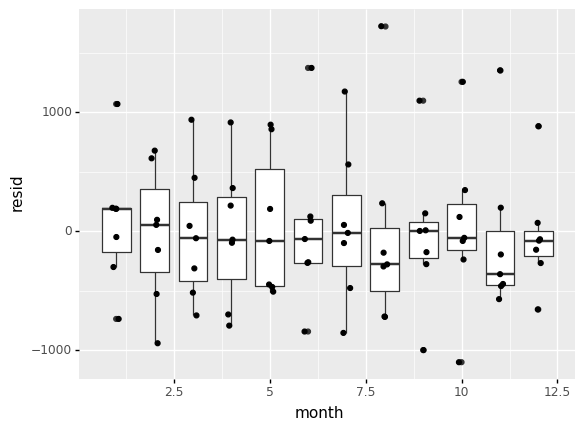

<ggplot: (8776173861145)>

In [31]:
df_combined["month"] = df_combined["date"].dt.month
df_combined["year"] = df_combined["date"].dt.year
df_combined["resid"] = df_combined["traffic"] - df_combined["traffic_pred_weekly"]
df_temp = df_combined.groupby(["month", "year"], as_index=False).apply(lambda x: pd.Series({'resid': np.mean(x.resid)}))

(
    ggplot(df_temp, aes(x='month', y='resid', group='month')) +
    geom_boxplot() +
    geom_jitter(width=0.1)
)

The above does seem to indicate, however, that there heteroscedasticity in the errors: there are times of the year when our predictions deviate only a little from the actual; there are other times when the deviations are much greater. A better model might allow the standard deviation of the model to vary by month, which we may explore later on.

Do we think that traffic trends have remained the same over time? Has traffic increased or decreased? To answer this, let's visualise our data again.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


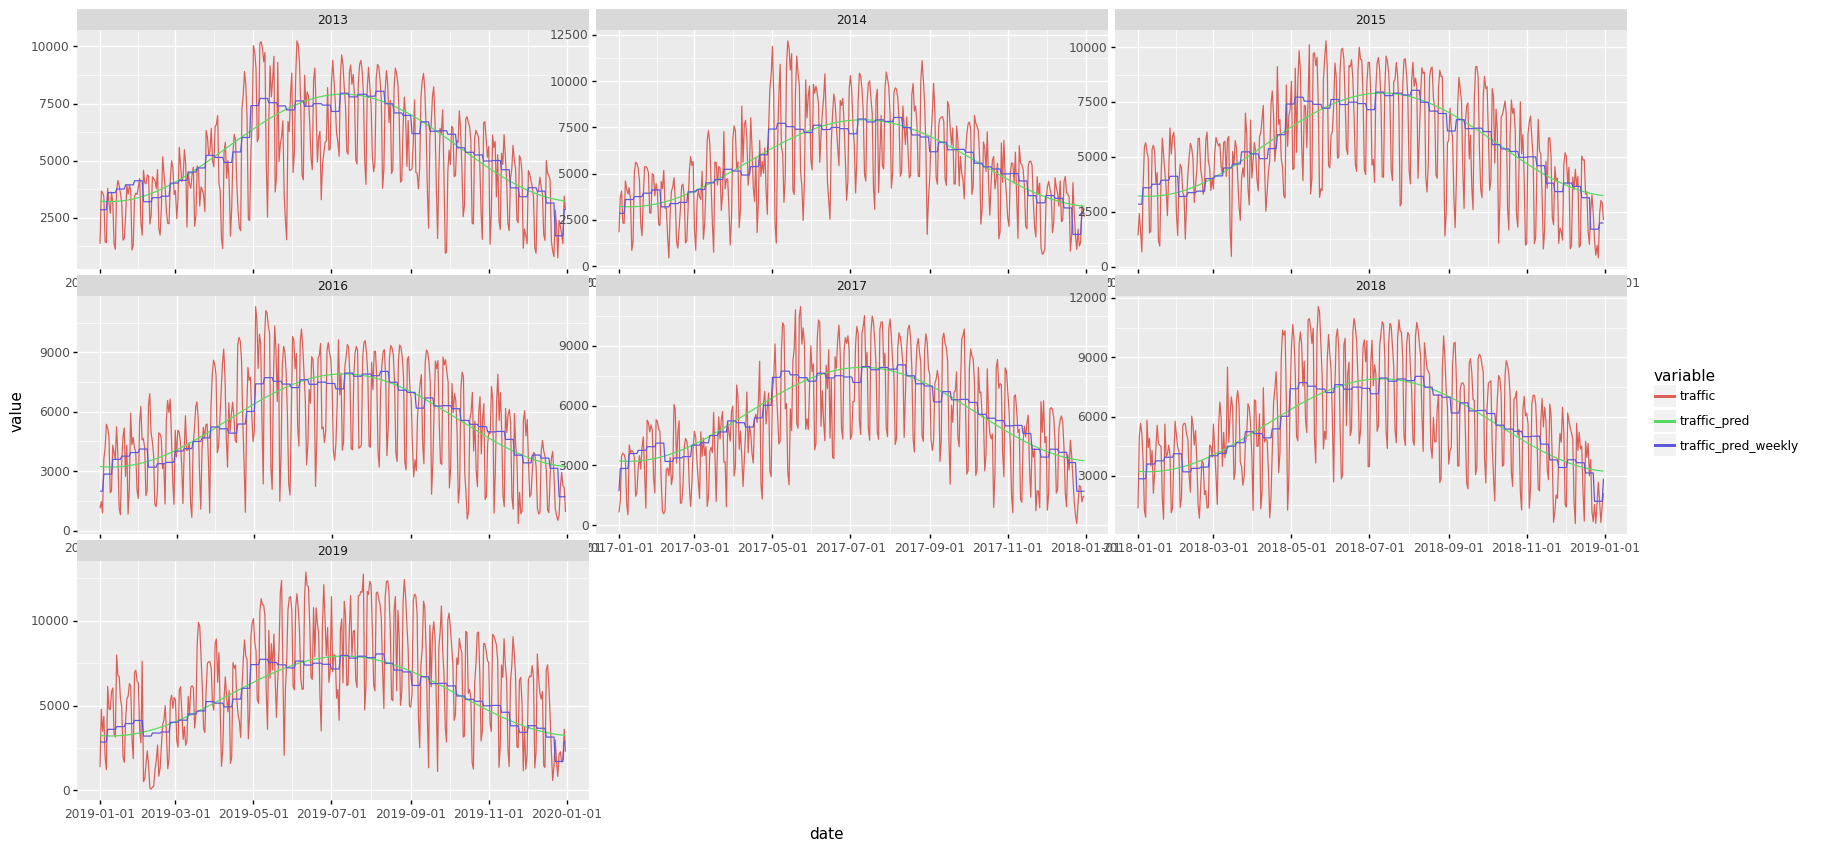

<ggplot: (8776137573928)>

In [32]:
df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred", "traffic_pred_weekly"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

From the above plot, it's clear that there is yearly variation in the data. Some years have lower traffic on average; others slightly more.

To handle this, let's try the simplest possible thing: including a linear time trend in our regression.

In [33]:
X = pd.concat([df_combined["t"], df_dummies], axis=1)
lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

LinearRegression()

Let's look at the coefficients: the time coefficient is positive.

In [34]:
lm.coef_[0]

0.4472027979571887

Let's plot the predictions using this model and compare to the previous ones.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/2819631294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


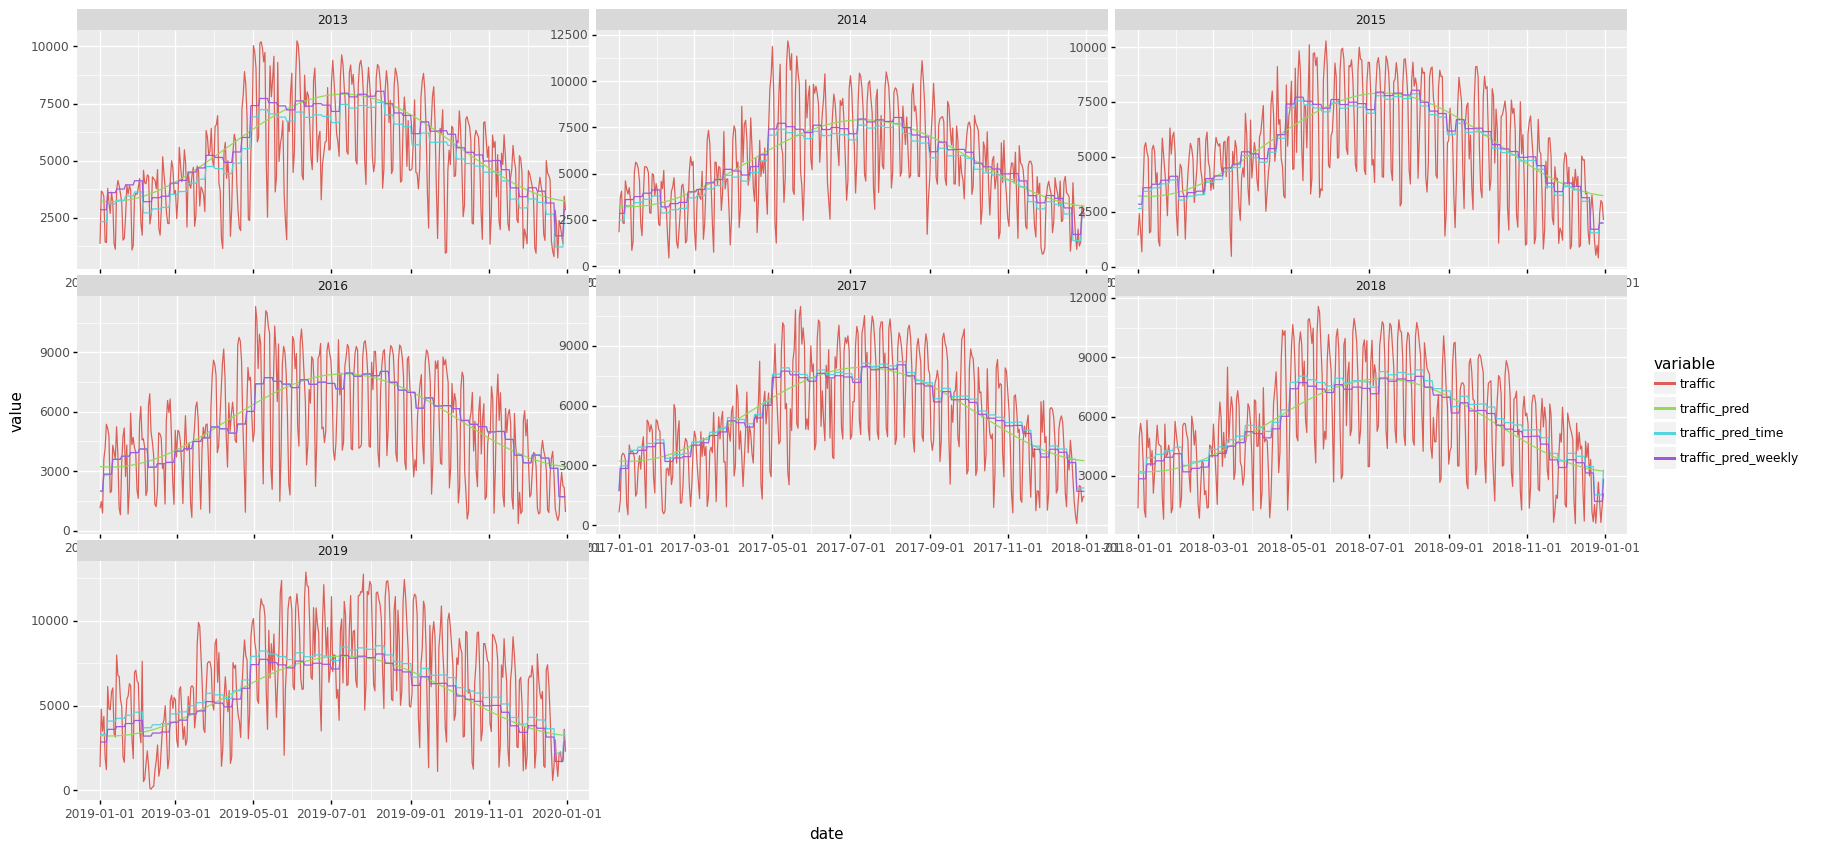

<ggplot: (8776187648211)>

In [35]:
df_combined["traffic_pred_time"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred", "traffic_pred_weekly", "traffic_pred_time"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

Hmm, it's hard to see whether the model with a linear time trend helps much from this. To be able to answer this question more completely, we'd probably want to do some sort of model comparison using a statistic like AIC, for instance. But, on first glances, it doesn't look like including a linear time trend has helped much.

One approach to handle this inter-annual variation is to fit yearly dummy variables. Of course, by doing so, this is effectively proxying for other explanatory factors which may explain the variation in the data. Also, by doing so, this may hinder our ability to predict a future year's data (since we won't know the coefficient for the new year). As such, let's not include yearly dummies.

Instead, let's focus on another glaring issue with the model. Namely, that the data shows considerably weekly variation, which we are currently completely ignoring. To see this more clearly, let's plot the traffic by day of the week.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/679261384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/679261384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


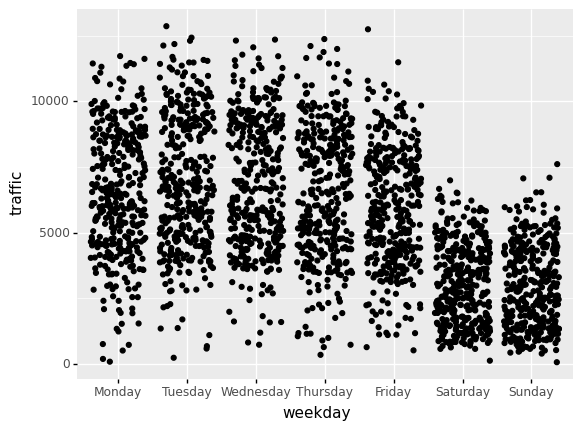

<ggplot: (8776120139783)>

In [36]:
df_combined["weekday"] = df_combined["date"].dt.day_name()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_combined["weekday"] = pd.Categorical(df_combined['weekday'], categories=cats, ordered=True)

(
    ggplot(df_combined, aes(x='weekday', y='traffic')) +
    geom_jitter()

)

So it looks like there are clear weekly patterns, where bike traffic on Saturday and Sunday is substantially lower than the other days of the week. There are also likely other patterns within the weekdays with, for example, there being lower traffic on Fridays. As such, we are going to create a dummy variable for each day of the week.

In [37]:
df_weekdaydummies = pd.get_dummies(df_combined["weekday"])

# drop Mondays since need a reference week
df_weekdaydummies.drop('Monday', inplace=True, axis=1)

Ok, so let's run our regression with weekly dummies, day of week dummies and linear time trend.

In [38]:
X = pd.concat([df_combined["t"], df_weekdaydummies, df_dummies], axis=1)

lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

LinearRegression()

Let's see how our new model's predictions fare.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/2918032911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


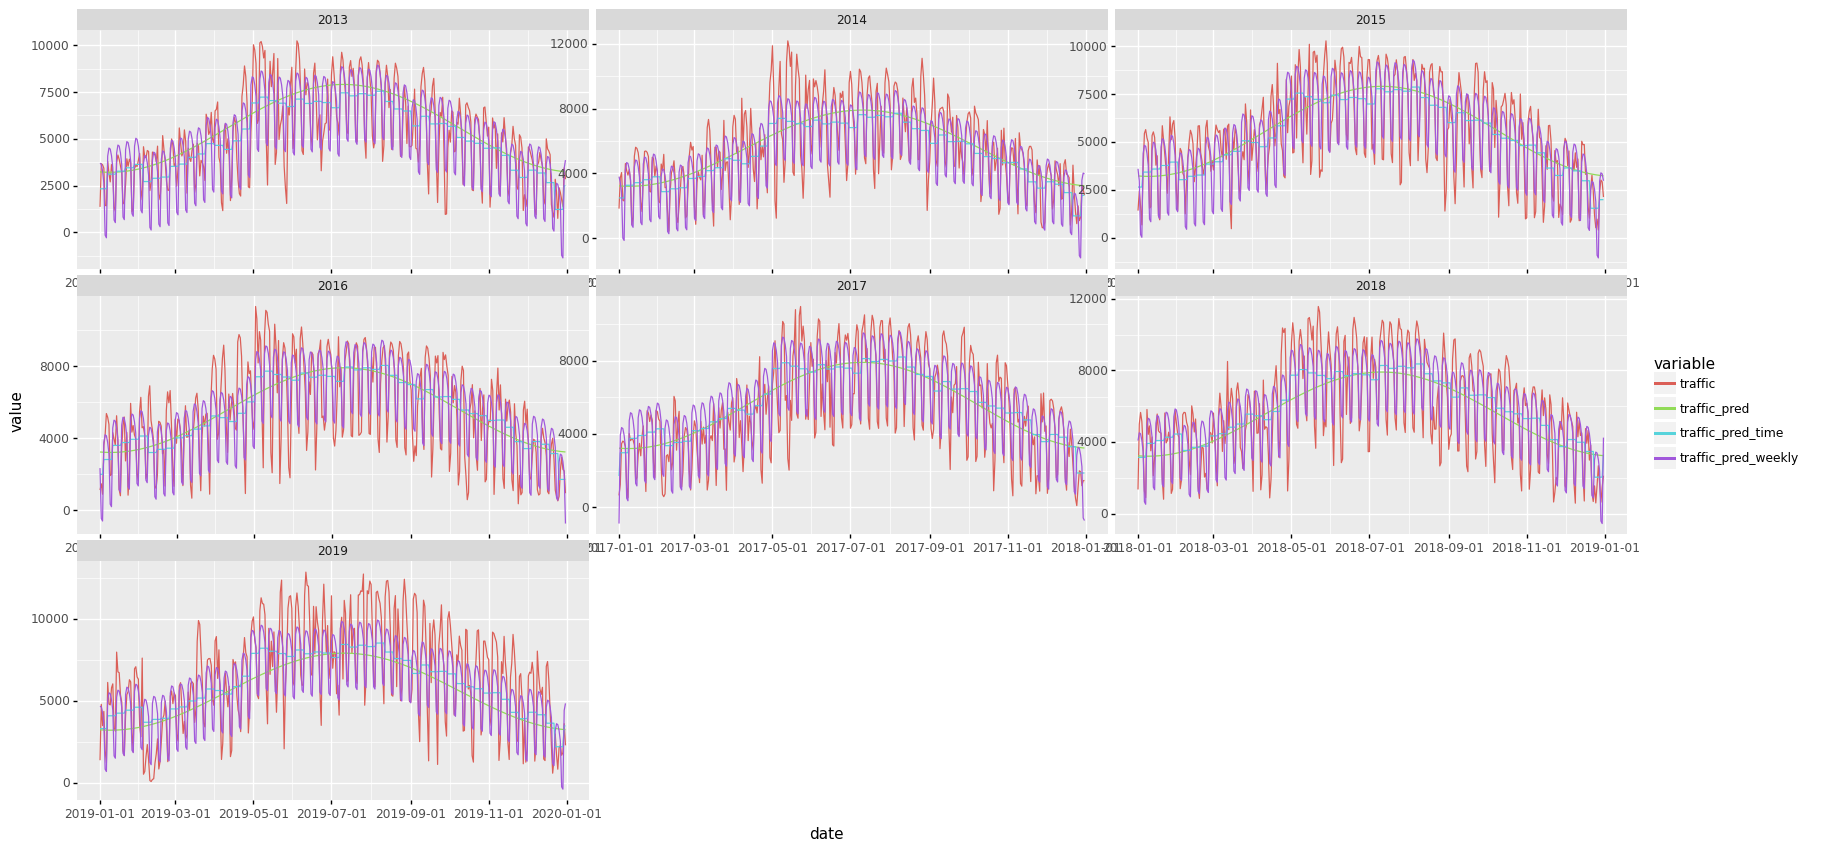

<ggplot: (8776137562378)>

In [39]:
df_combined["traffic_pred_weekly"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred", "traffic_pred_weekly", "traffic_pred_time"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

This is now starting to look much better. The model allowing weekly variation is much better able to capture the patterns in the data. Still, 2019 looks a bit strange and is a notable outlier in our data.

It also looks like there is more weekly variation in the summer than there is in the winter. Let's examine this by creating a "summer" dummy variable.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/4041809360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


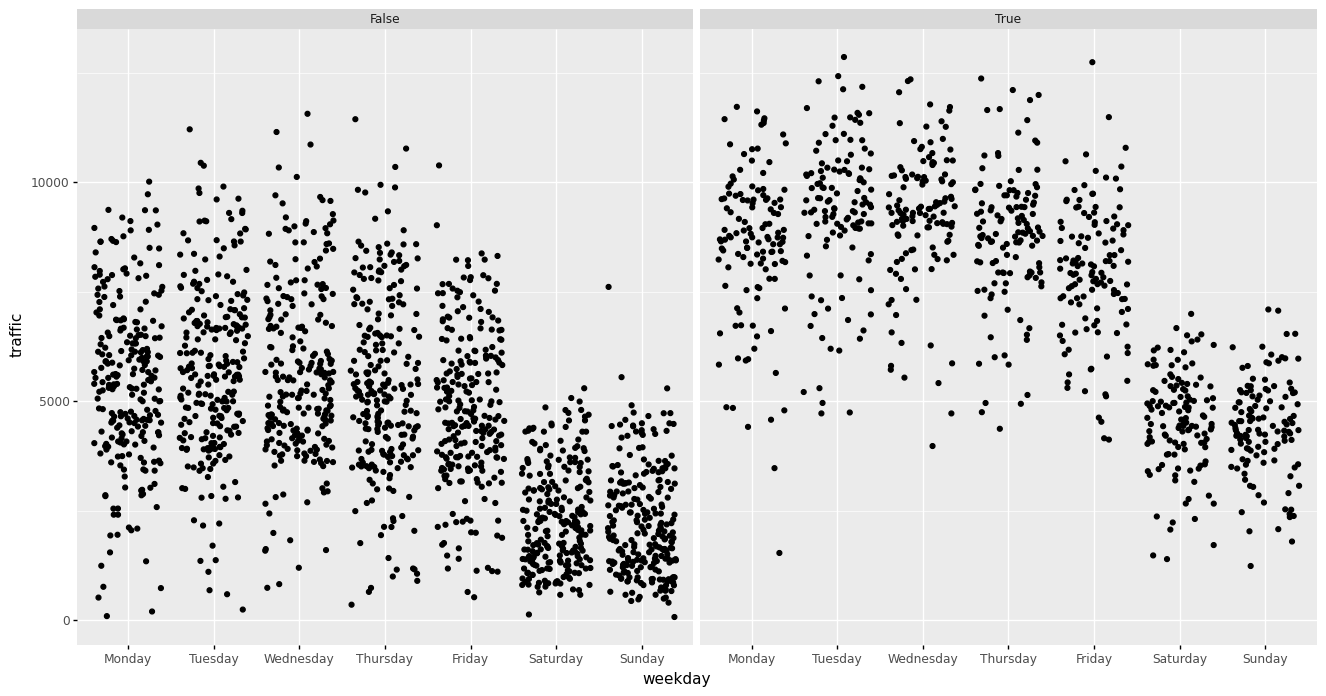

<ggplot: (8776188475158)>

In [40]:
df_combined["summer"] = df_combined["month"].isin([5, 6, 7, 8])
(
    ggplot(df_combined, aes(x='weekday', y='traffic')) +
    geom_jitter() +
    facet_wrap('summer') +
    theme(figure_size=(16, 8))
)

From this, it is clear that the absolute scale of variation is greater in the summer: the difference between weekday and weekend traffic is around 10,000; in the winter, the corresponding difference is around 4000.

To account for this, we are going to interact our sinusoidal variable with the weekday indicators and also include these in the regression. Of course, we could have interacted the weekly dummies with the weekday indicators but this would create loads of variables.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/667852249.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


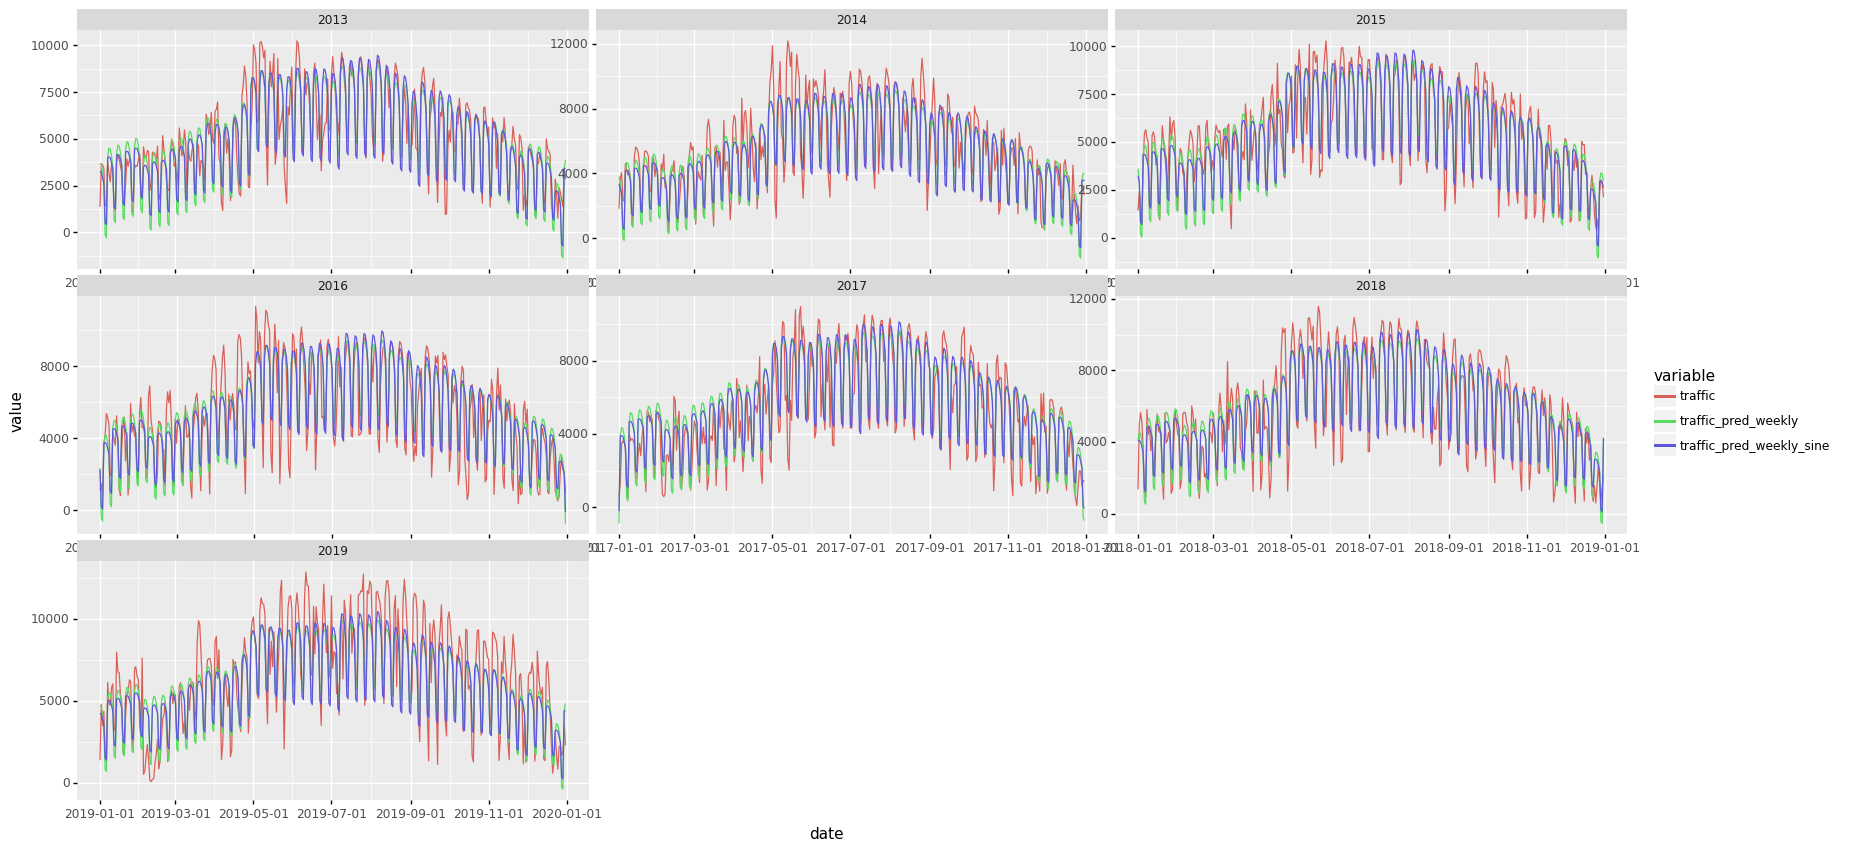

<ggplot: (8776174642661)>

In [41]:
df_weekdaysine = df_weekdaydummies.mul(df_combined["sin_t"], axis=0)
df_weekdaycos = df_weekdaydummies.mul(df_combined["cos_t"], axis=0)

X = pd.concat([df_combined["t"], df_weekdaydummies, df_dummies, df_weekdaysine, df_weekdaycos], axis=1)

lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

df_combined["traffic_pred_weekly_sine"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred_weekly", "traffic_pred_weekly_sine"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

This model appears to be doing a slightly better job of representing the differences in weekly variation throughout the year. Again, 2019 is a bit of an outlier.

Could it be that 2019 had better weather? Let's graph the temperature data.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/1324805014.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/1324805014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 90 rows containing missing values.


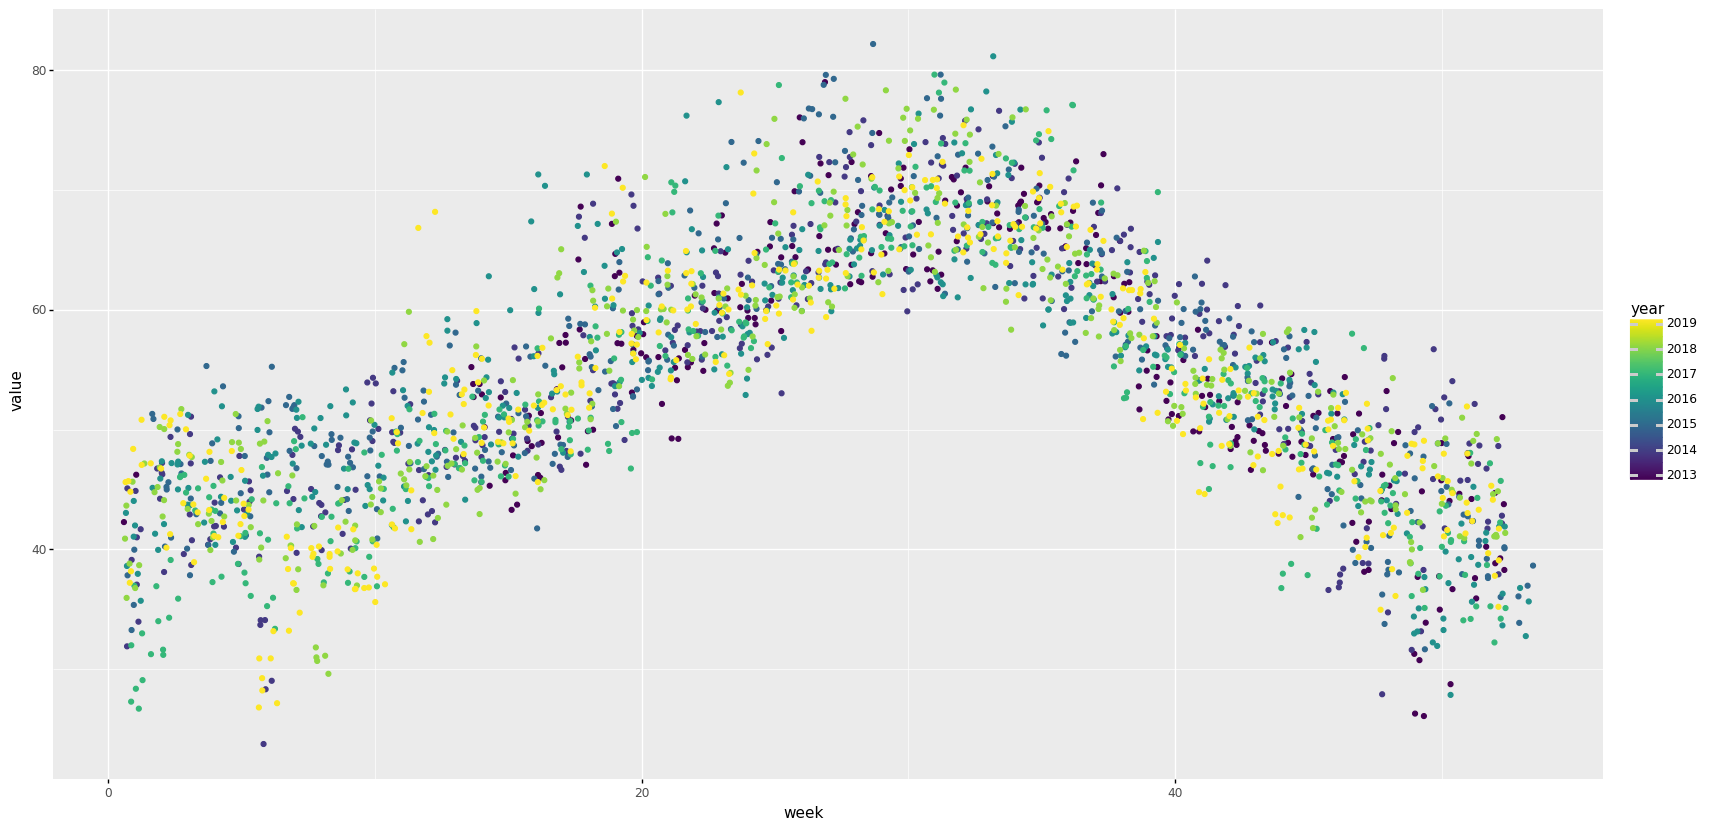

<ggplot: (8776155140645)>

In [42]:
df_combined["week"] = df_combined["date"].dt.week

df_new = (
    df_combined[["week", "year", "temperature"]].
    melt(["week", "year"])
)

(
    ggplot(df_new, aes(x='week', y='value', colour='year')) +
    geom_jitter() +
    theme(figure_size=(20, 10))
)

The above plot doesn't seem to implicate the average temperature as a strong determinant of inter-annual variation. But the average temperature does possibly explain some of the variation within years. For example, in the early part of 2019, traffic was relatively low and so was temperature, so it's possible that temperature could be an important driver. Also, it may be that temperature is actually the main force responsible for the seasonality seen in the traffic data, since it follows very similar seasonal patterns to it.

Let's plot traffic versus temperature.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 90 rows containing missing values.


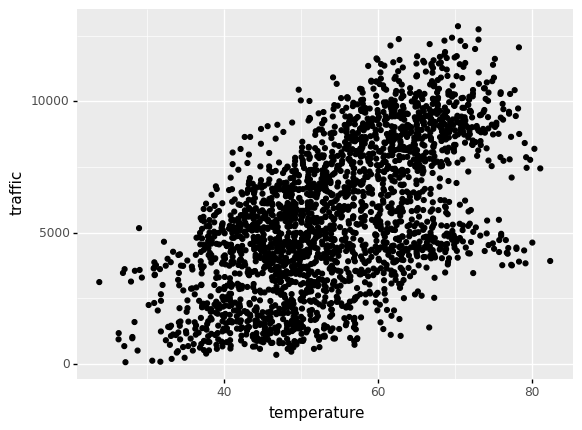

<ggplot: (8776188467646)>

In [43]:
(
    ggplot(df_combined, aes(x='temperature', y='traffic')) +
    geom_jitter()
)

The above shows that there is a positive association between temperature and traffic but likely at a declining rate with increased temperature. As such, let's include temperature and the square of temperature in our regression. To do so, we need to drop the temperature recordings which are NaNs in our data.

We are also going to drop our weekly dummies, since our supposition is that temperature is the factor that actually drives the seasonal variation.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/887876055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/887876055.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

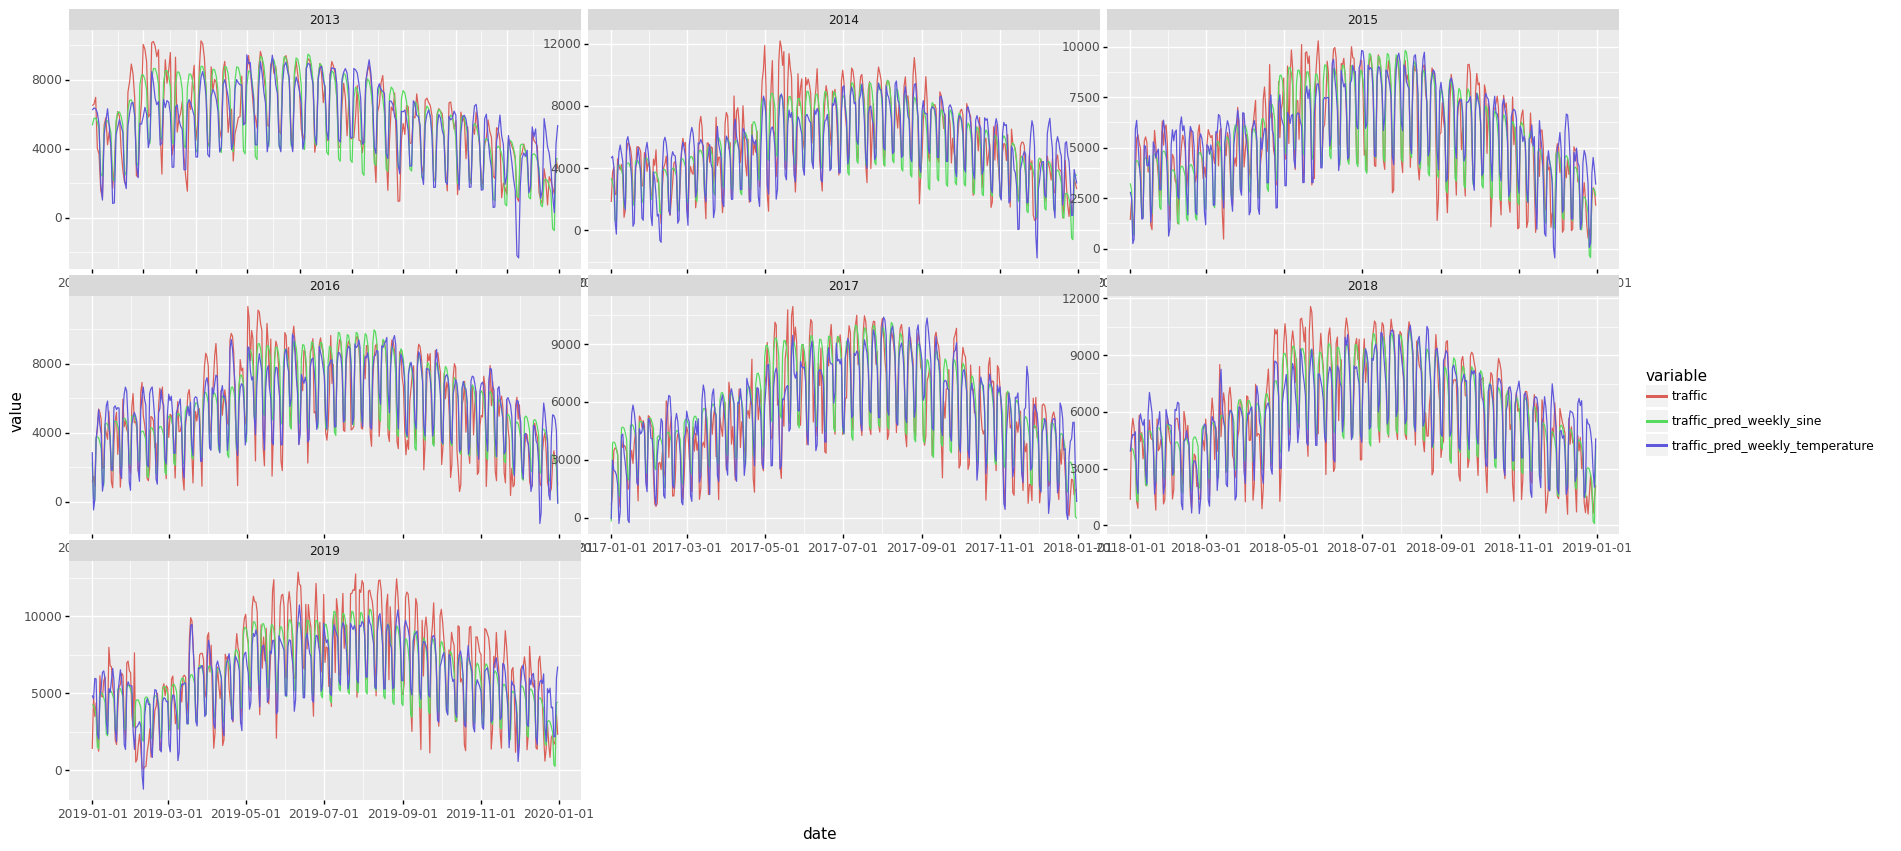

<ggplot: (8776155216812)>

In [44]:
df_combined["temperature_sq"] = df_combined["temperature"]**2

df_combined.dropna(inplace=True)

df_weekdaydummies = pd.get_dummies(df_combined["weekday"])

# drop Mondays since need a reference week
df_weekdaydummies.drop('Monday', inplace=True, axis=1)

X = pd.concat([df_combined["t"], df_weekdaydummies,
               df_combined["temperature"], df_combined["temperature_sq"]], axis=1)

lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

df_combined["traffic_pred_weekly_temperature"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred_weekly_sine", "traffic_pred_weekly_temperature"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

The performance of the above model that includes only the linear time trend, day of week dummies and temperature variables is admirable. Particularly, because it is a far simpler and less "black boxy" interpretation of the data: in the models with the temperature variables, temperature is the factor that mainly causes the seasonal patterns in traffic. 

What about rain? It seems reasonable that people may be less likely to travel when it's raining.

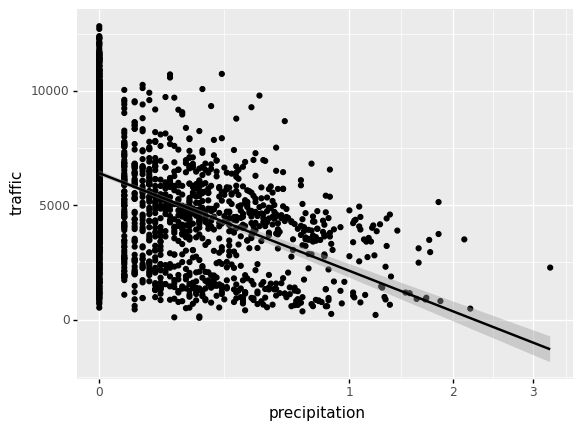

<ggplot: (8776188087179)>

In [45]:
(
    ggplot(df_combined, aes(x='precipitation', y='traffic')) +
    geom_point() +
    scale_x_sqrt() +
    geom_smooth()
)

This seems to be the case. So let's include precipitation as a covariate in the regression.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/4273993639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


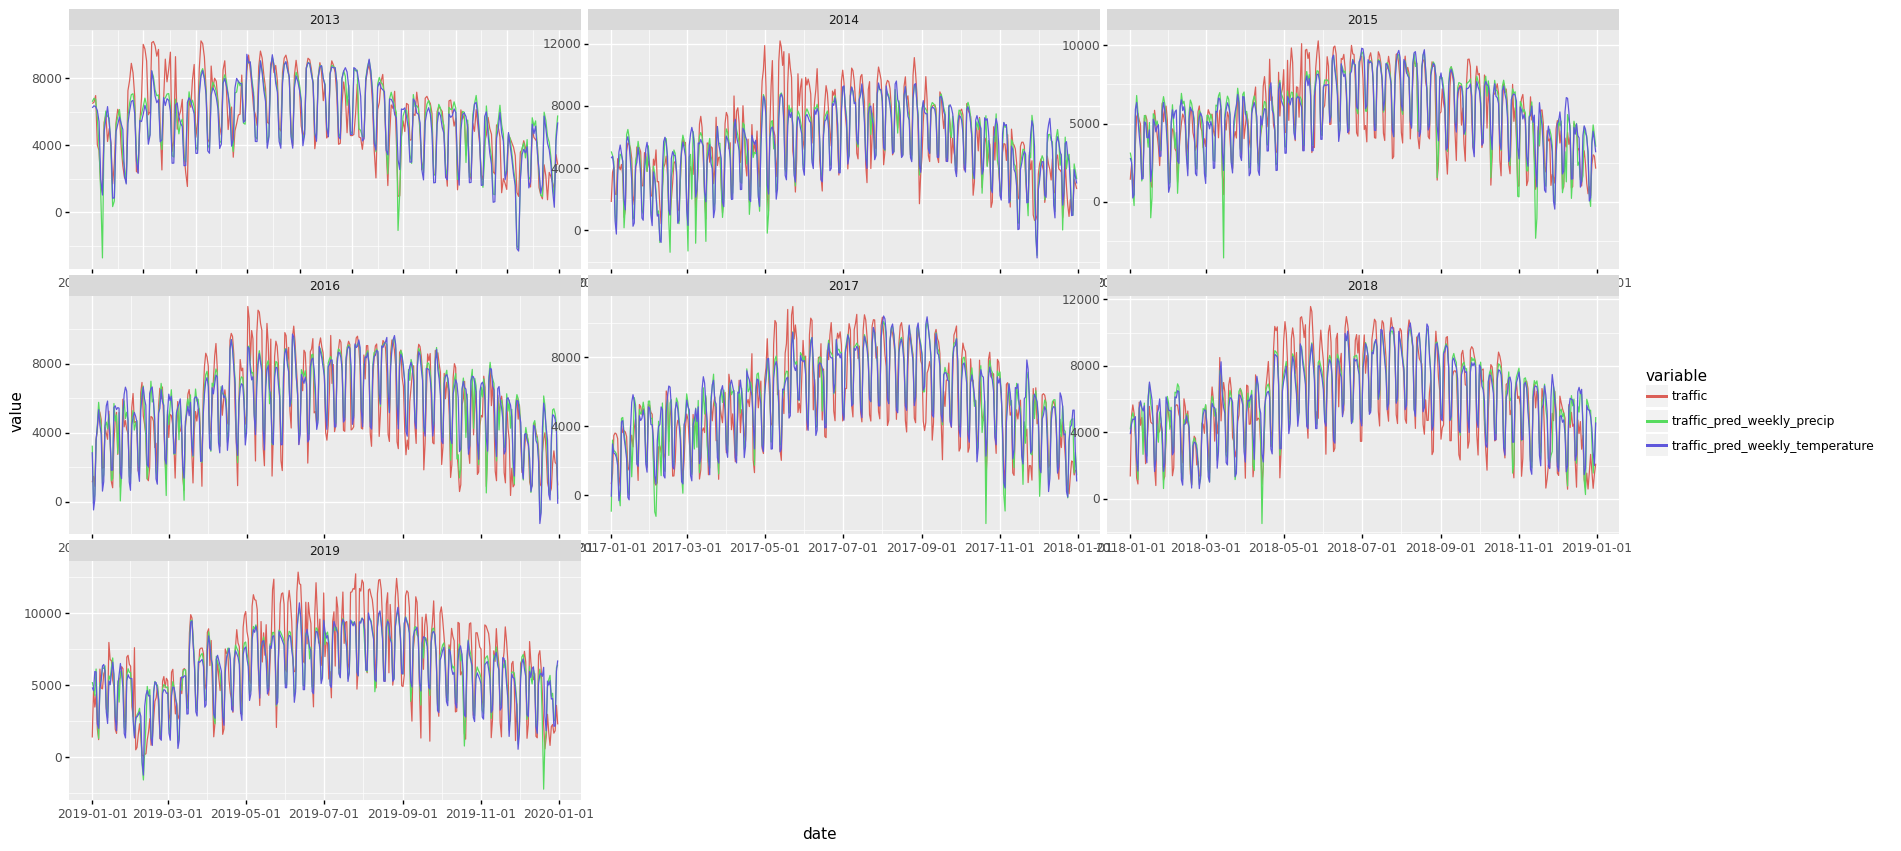

<ggplot: (8776137886431)>

In [46]:
X = pd.concat([df_combined["t"], df_weekdaydummies,
               df_combined["temperature"], df_combined["temperature_sq"],
               df_combined["precipitation"]], axis=1)

lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

df_combined["traffic_pred_weekly_precip"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred_weekly_temperature", "traffic_pred_weekly_precip"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

Hmm, this model seems to output some unreasonable predictions. It is likely that precipitation may affect traffic in a non-linear way, so let's include the square of precipitation in our model.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/2647149378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/2647149378.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/o

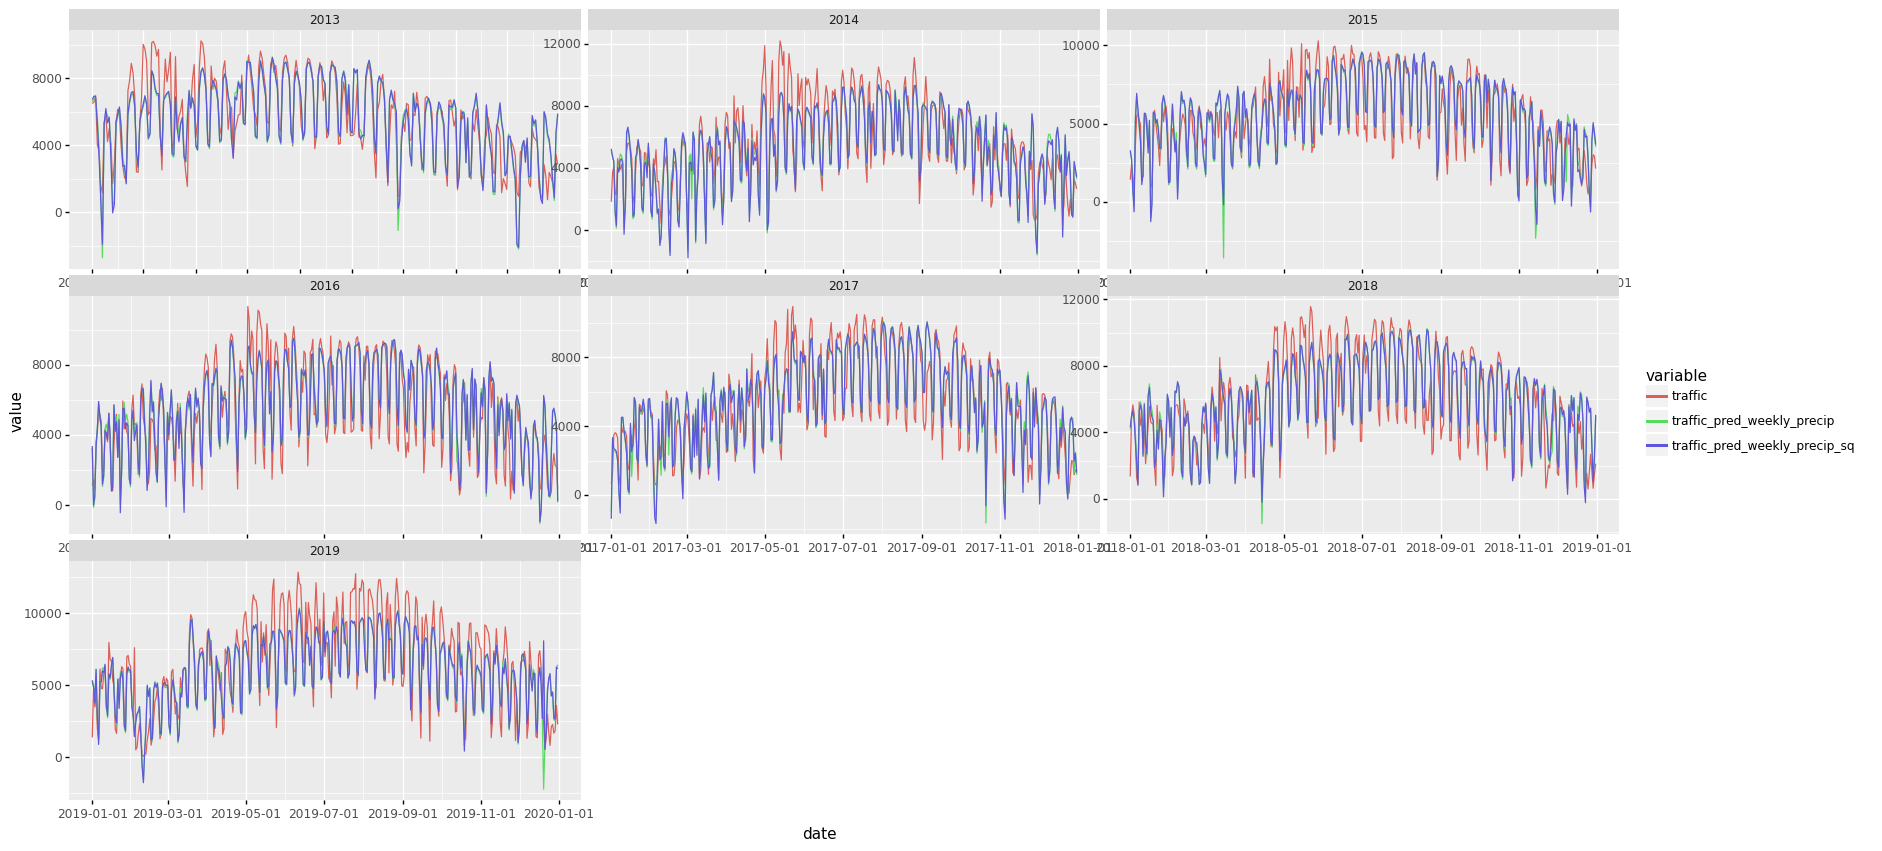

<ggplot: (8776173887805)>

In [47]:
df_combined["precipitation_sq"] = df_combined["precipitation"]**2

X = pd.concat([df_combined["t"], df_weekdaydummies,
               df_combined["temperature"], df_combined["temperature_sq"],
               df_combined["precipitation"], df_combined["precipitation_sq"]], axis=1)

lm = LinearRegression()
lm.fit(X, df_combined["traffic"])

df_combined["traffic_pred_weekly_precip_sq"] = lm.predict(X)

df_new = (
    df_combined[["date", "year", "traffic","traffic_pred_weekly_precip",
                 "traffic_pred_weekly_precip_sq"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

The outlier predictions are now less extreme than before. Including the square term thus seems a reasonable thing to do.

Let's not plot the actual vs predicted observations to test whether our model is able to equally explain both high and low traffic. In these plots, I also include a line going through the origin with a slope of 1 and a loess regression line.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


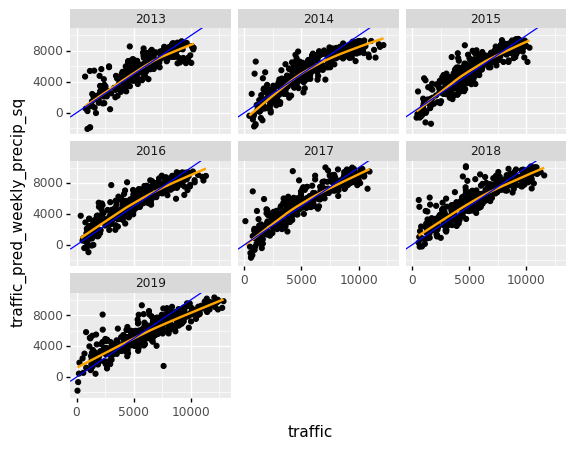

<ggplot: (8776173894934)>

In [48]:
(
    ggplot(df_combined, aes(x='traffic', y='traffic_pred_weekly_precip_sq')) +
    geom_point() +
    geom_smooth(colour="orange") +
    geom_abline(colour="blue") +
    facet_wrap('year')
)

This shows that the model is not performing great at the lower and upper ends of the traffic scale: it is overpredicting on days when there's actually low traffic and underpredicting when there's lots of traffic. This is symptomatic of interaction effects between the variables and suggests that modelling the log of traffic may be more sensible because:

$$ \log \text{traffic} = \alpha + b X_1 + c X_2 $$

implies that:

$$ \text{traffic} = \exp(\alpha) \exp(b X_1) \exp(c X_2).$$

In other words, this allows there to be general interactions between variables in the regression.

Let's try this out.

/var/folders/_f/0kqrxwdn69vgvgb02z2m3kqc0000gp/T/ipykernel_11905/1084618233.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


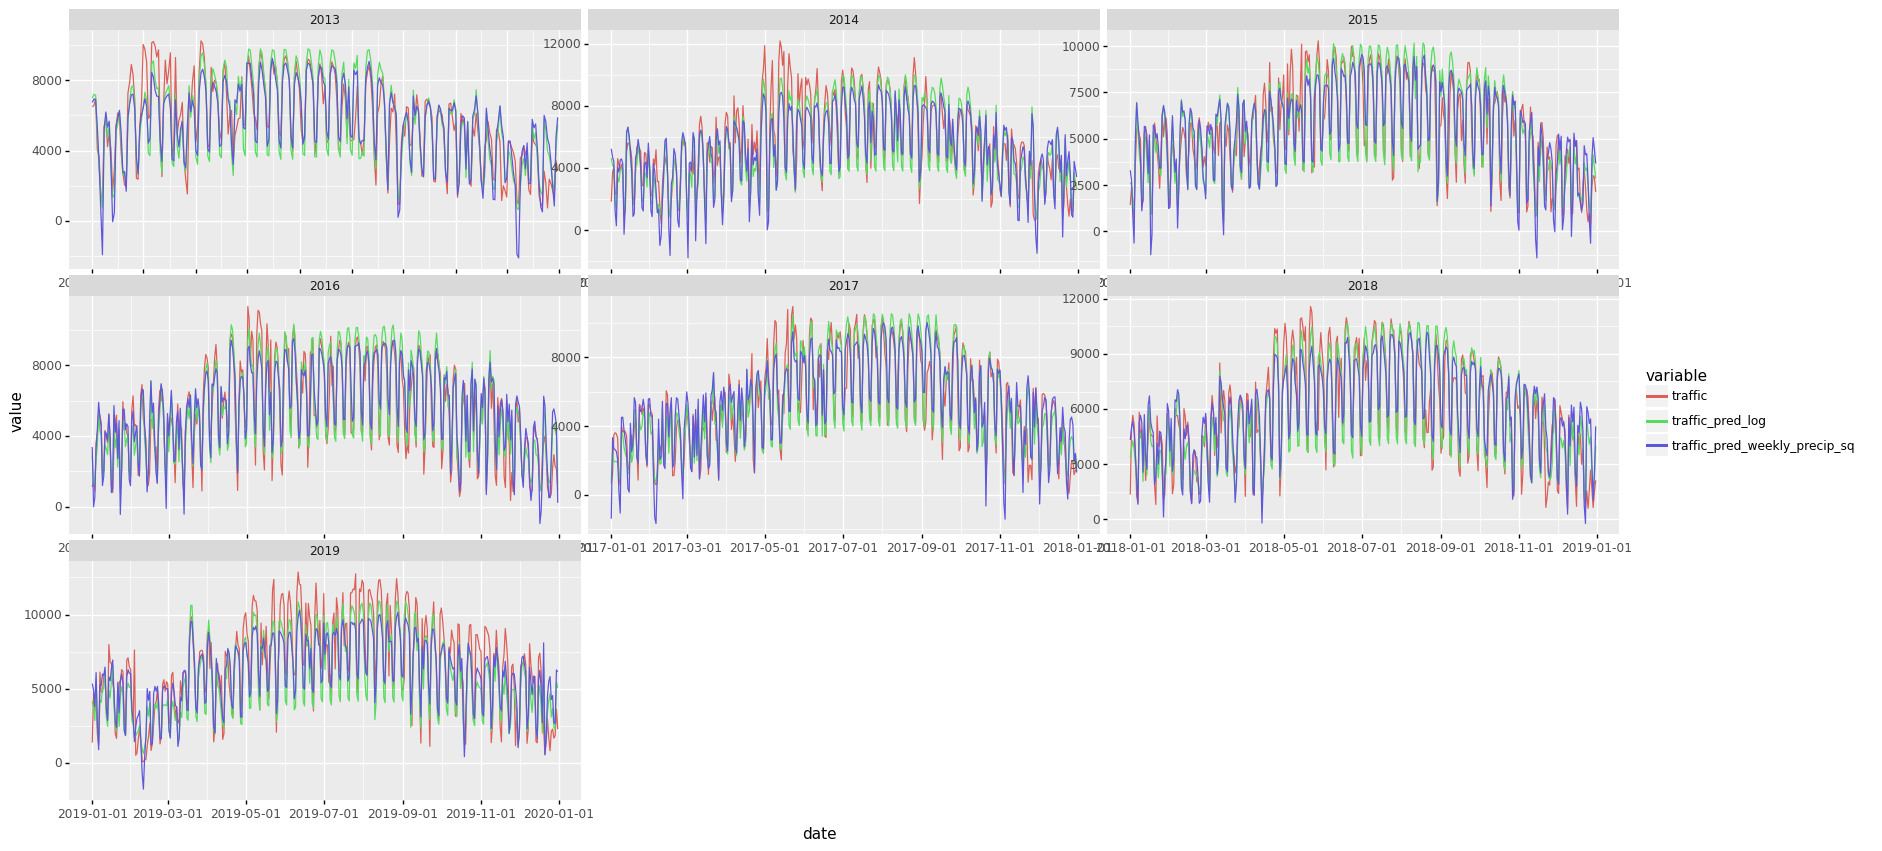

<ggplot: (8776173895003)>

In [49]:
X = pd.concat([df_combined["t"], df_weekdaydummies,
               df_combined["temperature"], df_combined["temperature_sq"],
               df_combined["precipitation"], df_combined["precipitation_sq"]], axis=1)

lm = LinearRegression()
lm.fit(X, np.log(df_combined["traffic"]))

# exponent predictions
df_combined["traffic_pred_log"] = np.exp(lm.predict(X))

df_new = (
    df_combined[["date", "year", "traffic", "traffic_pred_weekly_precip_sq",
                 "traffic_pred_log"]].
    melt(["date", "year"])
)

(
    ggplot(df_new, aes(x='date', y='value')) +
    geom_line(aes(colour='variable')) +
    facet_wrap("year", scales="free") +
    theme(figure_size=(20, 10))
)

Ok, the logged-dependent variable model is producing visually better fits to the data. Let's look at the actual vs predicted plots again.

/Users/bcl206/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


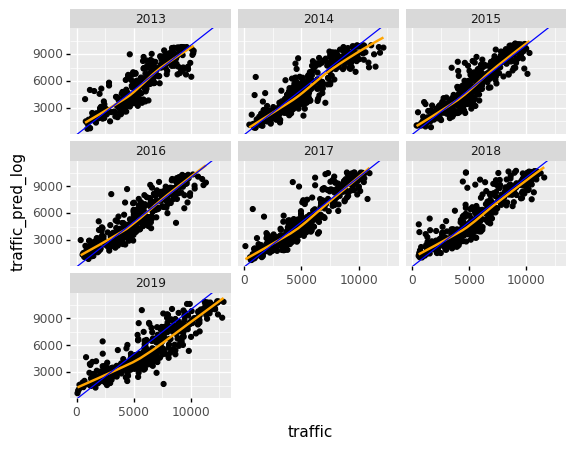

<ggplot: (8776174638885)>

In [50]:
(
    ggplot(df_combined, aes(x='traffic', y='traffic_pred_log')) +
    geom_point() +
    geom_smooth(colour="orange") +
    geom_abline(colour="blue") +
    facet_wrap('year')
)

Ah, that's much better. Apart from 2019, when things are a bit awry, the model with a logged dependent variable fares much better.

We've now arrived at a models which seems to provide a reasonable description of the traffic data. Of course, we could continue to probe whether the assumptions of our model are reasonable by continuing to produce diagnostic plots. And, if I were going to produce a publication based on this data, I would want to do so. But as a first go, I'm happy with this model for our current purposes.

There are also many extensions we could make to the model including:

- include dummies for key holidays
- include the impact of other factors such as the level of wind
- allow a process which generates the inter-annual variation; particularly anything that can explain 2019's weird data. To do so, we would probably want to speak to someone in Seattle who was more acquainted with the data than us!